In [2]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
### Import functions from peak_functions

repository_path = os.path.abspath('..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf

In [6]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 12

In [7]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-06_02_2023-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

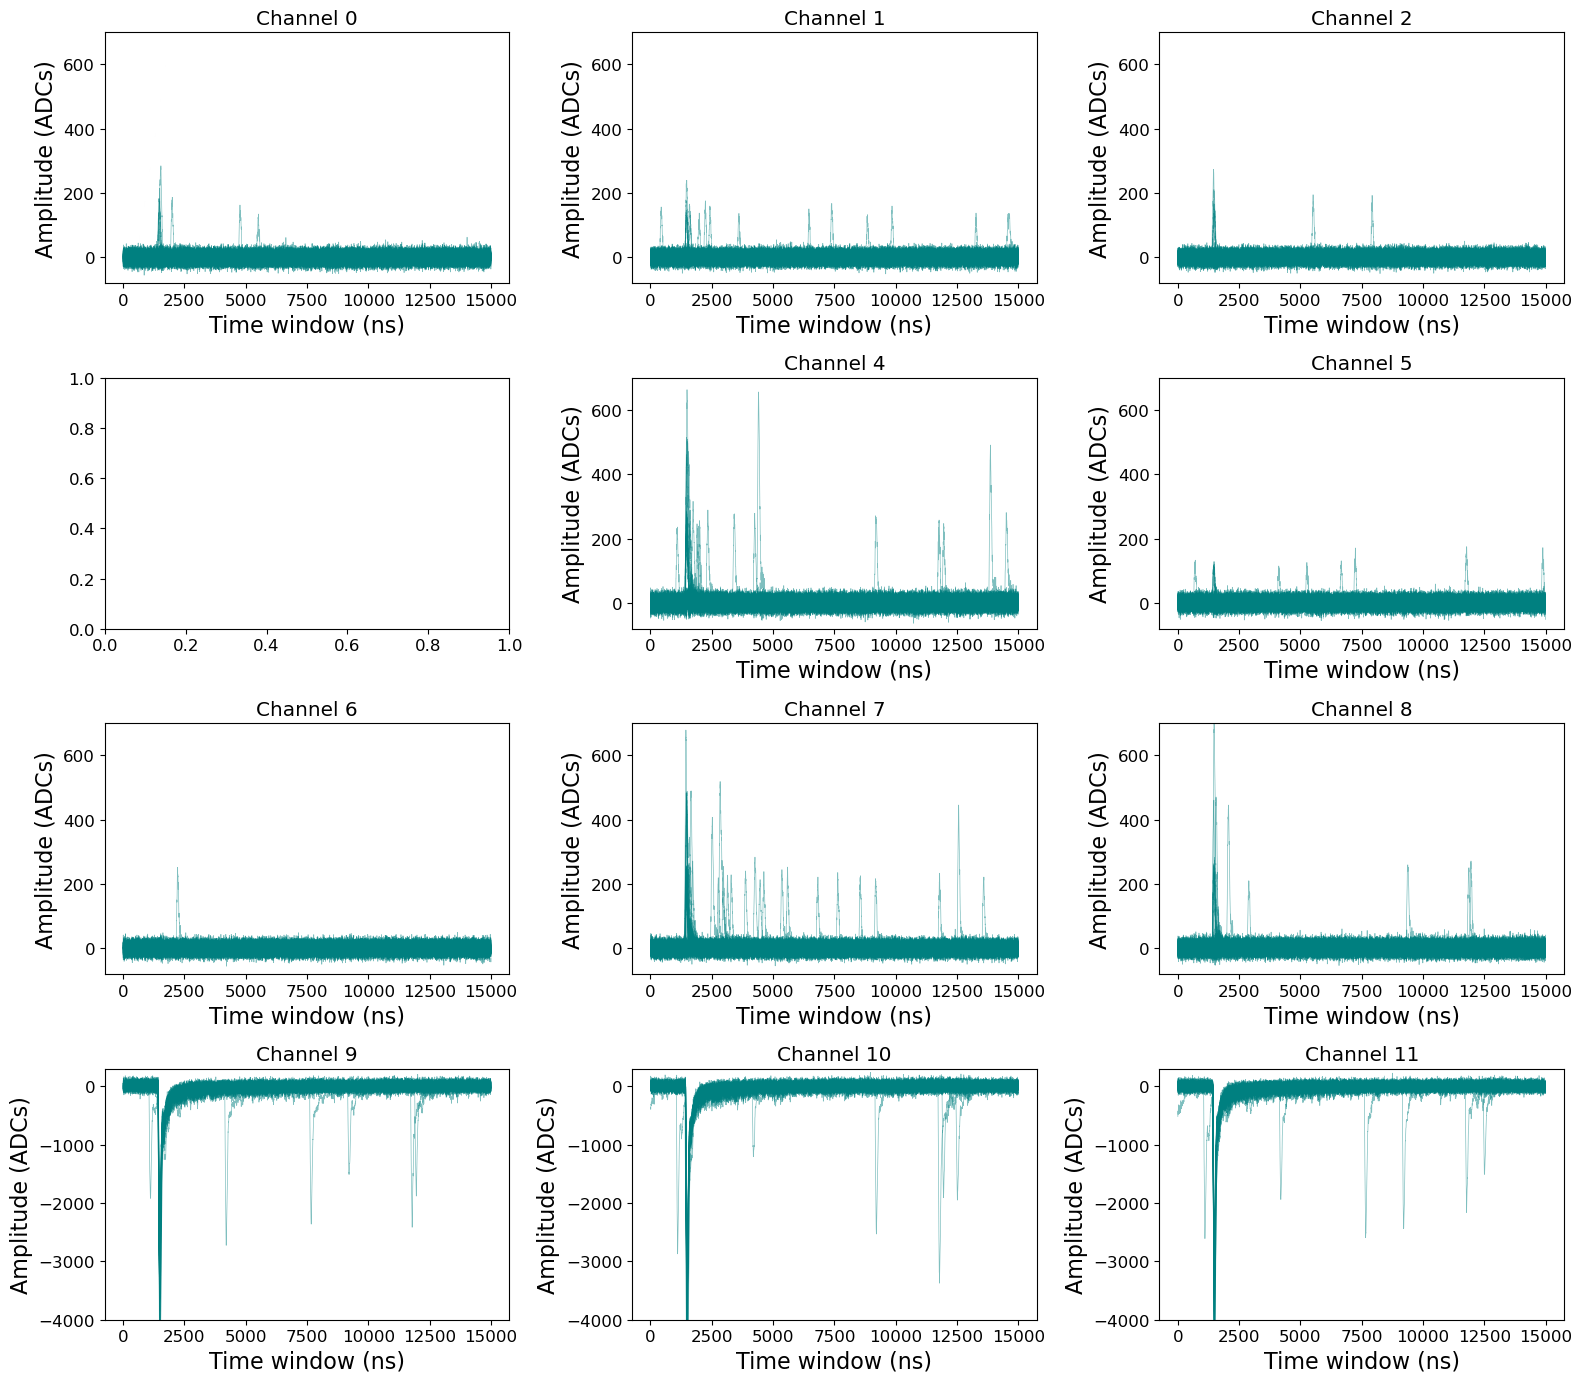

In [79]:
num_evts = 50
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for k in range(12):
    if k==3: continue
    i = int(k/3)
    j = k%3
    wfs      = np.array(RawTree[f'chan{k}/rdigi'].array())[:num_evts]
    subt_wfs = list(map(pf.subtract_baseline, wfs))
    for swf in subt_wfs:
        axs[i][j].plot(2*np.arange(len(swf)), swf, linewidth=0.5, color='teal', alpha=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_title(f"Channel {k}")
    #axs[i][j].set_xlim(1300, 1700)
    if k < 9:
        axs[i][j].set_ylim(-80, 700)
    else:
        axs[i][j].set_ylim(-4000, 300)
plt.tight_layout()
plt.show()

379
711
997


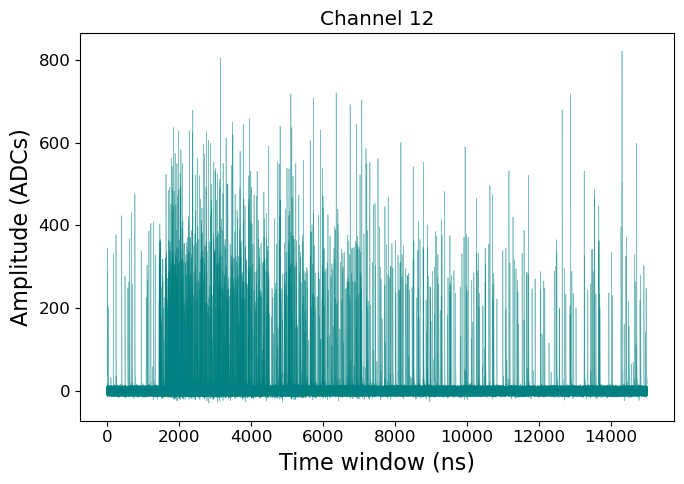

In [29]:
num_evts = 1000
channel  = 12
wfs      = np.array(RawTree[f'chan{channel}/rdigi'].array())[:num_evts]
plt.figure(figsize=(7, 5))
for evt, wf in enumerate(wfs):
    cwf = blr.pmt_deconvolver(wf)
    if max(cwf)>1000:
        print(evt)
        continue
    plt.plot(2*np.arange(len(cwf)), cwf, linewidth=0.5, color='teal', alpha=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.title(f"Channel {channel}")
#plt.xlim(1200, 2000)
plt.tight_layout()
plt.show()

In [77]:
def find_wfs_above_thr(wfs, thr):        
    indices_above_thr = [idx for idx, wf in enumerate(wfs) if len(wf[wf>thr]) > 0]
    return np.array(indices_above_thr)

def get_saturating_evts_using_pmt_signal(RawTree, pmt_channel=12, pmt_thr=1000):
    ## Get saturating events using PMT info
    pmt_raw_wfs     = np.array(RawTree[f'chan{pmt_channel}/rdigi'].array())
    pmt_cwfs        = np.array([blr.pmt_deconvolver(wf) for wf in pmt_raw_wfs])
    saturating_evts = find_wfs_above_thr(pmt_cwfs, thr=pmt_thr)
    saturating_evts = list(filter(find_wfs_above_thr, pmt_cwfs))
    return saturating_evts

def remove_waveforms_by_indices(waveforms, indices_to_remove):
    filtered_waveforms = np.delete(waveforms, indices_to_remove, axis=0)
    return filtered_waveforms

def get_peaks_peakutils(waveform):
    return peakutils.indexes(waveform, thres=0.35, min_dist=100)

def get_peaks_using_peakutils(RawTree, channel, sipm_thr=50, pmt_thr=1000, peak_range=(650,850)):
    all_raw_wfs       = np.array(RawTree[f'chan{channel}/rdigi'].array())
    
    ## Subtract baseline
    subt_raw_wfs      = list(map(pf.subtract_baseline, all_raw_wfs))
    
    ## Get and remove saturated events from PMTs
    saturated_evts    = get_saturating_evts_using_pmt_signal(RawTree, pmt_thr=pmt_thr)
    filt_wfs          = remove_waveforms_by_indices(subt_raw_wfs, saturated_evts)
    
    ## Zero suppression
    zs_raw_wfs        = pf.noise_suppression(filt_wfs, threshold=sipm_thr)
    
    ## Remove events with no signal in the ROI
    empty_evts        = np.array([idx for idx, zwf in enumerate(zs_raw_wfs) if np.sum(zwf[peak_range[0]:peak_range[1]])==0])
    filter_empty_zwfs = remove_waveforms_by_indices(zs_raw_wfs, empty_evts)
    subt_raw_wfs_filt = remove_waveforms_by_indices(filt_wfs,   empty_evts)
    
    ## Get the peaks found in the ROI
    all_peaks         = list(map(get_peaks_peakutils, filter_empty_zwfs))
    return filter_empty_zwfs, subt_raw_wfs_filt, all_peaks

In [78]:
get_peaks_using_peakutils(RawTree, channel=8)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[  0.,   2.,   0., ..., -20., -12.,  -1.],
        [  9.,  12.,  17., ...,  15.,   1.,   0.],
        [-26., -11.,   1., ...,   9.,  11.,  10.],
        ...,
        [ 23.,  27.,  26., ...,   0.,  -5.,   9.],
        [  8.,   6.,  -1., ...,   8.,   5.,   5.],
        [ 14.,   6.,  33., ...,  12., -10., -17.]], dtype=float32),
 [array([735]),
  array([718]),
  array([727]),
  array([737]),
  array([779]),
  array([756]),
  array([759]),
  array([747]),
  array([736]),
  array([749]),
  array([739]),
  array([734]),
  array([804]),
  array([733]),
  array([747]),
  array([730]),
  array([2923]),
  array([728]),
  array([847]),
  array([722]),
  array([730]),
  array([744]),
  array([839]),
  array([748]),
  array([733]),